<a href="https://colab.research.google.com/github/lakshaygola/AnimeFaces-using-GANs-Pytorch-/blob/main/Gans_Human_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing the needed library for this project
!pip install opendatasets --upgrade --quiet
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 4.7MB/s 


In [ ]:
project_name= 'Gans-Human-Faces'

In [ ]:
# To download the dataset from the kaggle
import opendatasets as od

dataset_link= 'https://www.kaggle.com/ciplab/real-and-fake-face-detection'
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lakshaygola
Your Kaggle Key: ··········


  0%|          | 0.00/431M [00:00<?, ?B/s]

100%|██████████| 431M/431M [00:07<00:00, 64.4MB/s]


In [ ]:
# Exploring the folder and images in the dataset 
import os

data_dir= './real-and-fake-face-detection/real_and_fake_face'
print(os.listdir(data_dir))

['training_fake', 'training_real']


In [ ]:
# Importing some necessary library for the working
import torch
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.functional as f
from torchvision.utils import save_image
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Stats to normalization the image of the dataset
stats= (0.5,0.5,0.5) ,(0.5,0.5,0.5)
batch_size= 150
image_size= 64

In [ ]:
# The transformation we apply on each images of the dataset
images_transform= tt.Compose([tt.Resize(image_size), 
                              tt.CenterCrop(image_size), 
                              tt.ToTensor(), 
                              tt.Normalize(*stats)])

Now loading the dataset and apply the transformation on the images

In [ ]:
image_data= ImageFolder(data_dir,
                        transform= images_transform)

In [ ]:
# Creating the batch of the training data
train_loader= DataLoader(image_data,
                         batch_size= batch_size,
                         shuffle= True,
                         num_workers= 4,
                         pin_memory= True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Function to denormalize the data
def denorm(image):
  return image * stats[0][1] + stats[0][1]

# Function to make the grid of the images in dataset
def grid(image, nums= 70):
  fig, ax= plt.subplots(figsize= (15,15))
  ax.set_xticks([]), ax.set_yticks([])
  ax.imshow(make_grid(denorm(image.detach()[:nums]), nrow= 10).permute(1,2,0))

# To load the image from the batch and show them on the grid
def batch_show(batch, num=70):
  for image, _ in batch :
    grid(image)
    break

In [ ]:
image1= os.listdir(data_dir+'/training_real')[0]
image1

'real_00630.jpg'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


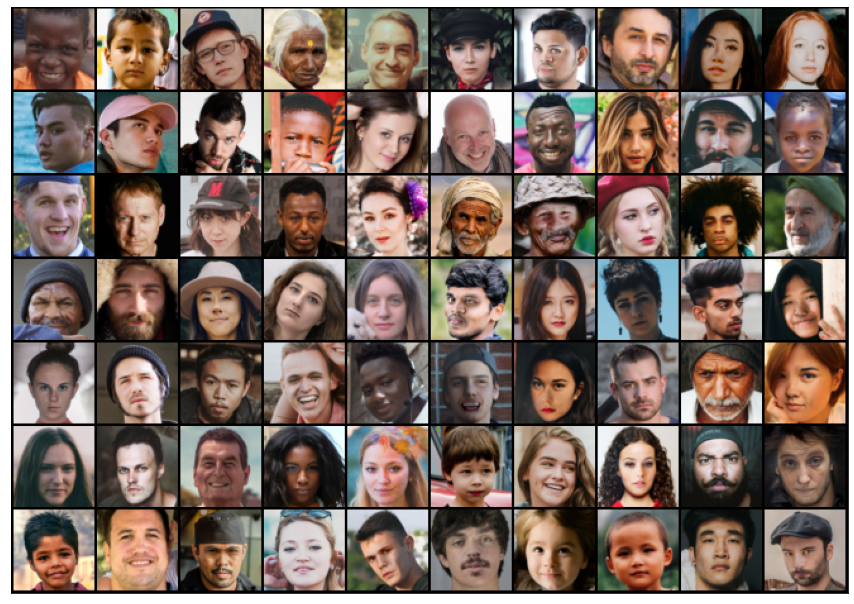

In [ ]:
# Lets see some images from the dataset
batch_show(train_loader)

##Function to use GPUs


In [ ]:
# Function to check weather we have gpus to work with or not
def device():
  if torch.cuda.is_available():
    return('cuda')
  else:
    return ('cpu')

#Function to move the data on avaiabel device
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking= True)

# Creating the claa to make the data batch on the given device
class datadeviceloader:
  def __init__(self, batch, device):
    self.dl= batch
    self.device= device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, device)

  def __len__(self):
    return len(self.dl)

In [ ]:
# Creating the discriminator model layers
discriminator= nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=4, padding=1, stride=2, bias= False),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2, bias= False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2, bias= False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(256, 512, kernel_size=4, padding=1, stride=2, bias= False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(512, 1, kernel_size=4, padding=0, stride=1, bias= False),

                nn.Flatten(),
                nn.Sigmoid()
)          

In [ ]:
# Latent size which will used to generate the image using model
latent_size= 128

In [ ]:
# Creating the layer of the model of generator
generator= nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, padding= 0, stride= 1, bias= False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace= True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, padding= 1, stride= 2, bias= False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace= True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, padding= 1, stride= 2, bias= False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace= True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, padding= 1, stride= 2, bias= False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace= True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, padding= 1, stride= 2, bias= False),
            nn.Tanh()

)

torch.Size([150, 3, 64, 64])


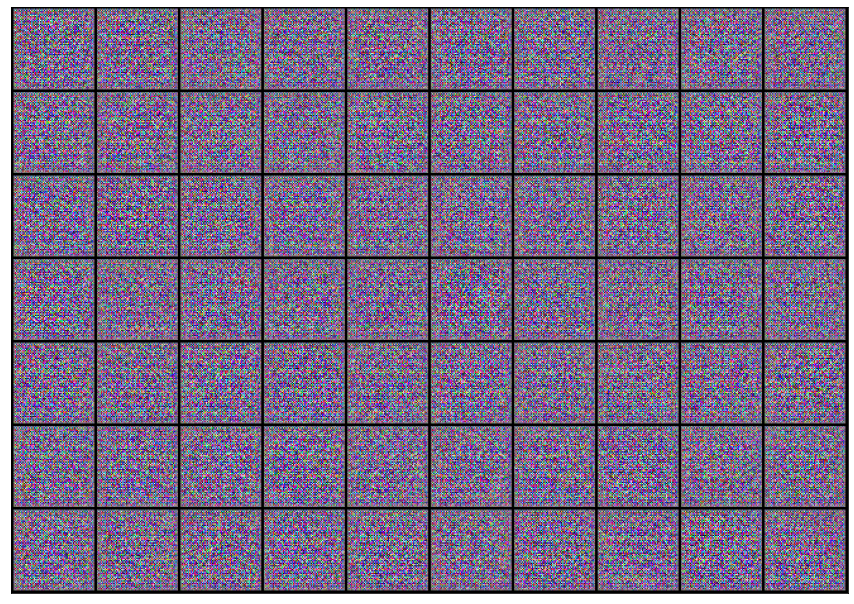

In [ ]:
# Trying the generator function by creating the fake image as 
#we do not train our model so we dont get any useful picture for the model

xb= torch.randn([batch_size, latent_size, 1, 1])
fake_image= generator(xb)
grid(fake_image)
print(fake_image.shape)

In [ ]:
# Getting the availabel device
device= device()
device

'cpu'

In [ ]:
# Moving the data batch on the avialable device
train_loader= datadeviceloader(train_loader, device)

In [ ]:
to_device(discriminator, device)
to_device(generator, device)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
def discri_train(image, opt_d):
  opt_d.zero_grad()

  real_pred= discriminator(image)
  real_target= torch.ones(image.size(0), 1, device= device)
  real_loss= F.binary_cross_entropy(real_pred, real_target)
  real_score= torch.mean(real_loss).item()

  latent= torch.randn(batch_size, latent_size, 1, 1, device= device)
  fake_image= generator(latent)

  fake_pred= discriminator(fake_image)
  fake_target= torch.zeros(fake_image.size(0), 1, device= device)
  fake_loss= F.binary_cross_entropy(fake_pred, fake_target)
  fake_score= torch.mean(fake_loss).item()

  loss= fake_loss + real_loss 
  loss.backward()
  opt_d.step()

  return real_score, fake_score, loss.item()

In [ ]:
def genera_train(opt_g):
  opt_g.zero_grad()

  latent= torch.randn(batch_size, latent_size, 1, 1, device= device)
  fake_image= generator(latent)

  pred= discriminator(fake_image)
  target= torch.ones(fake_image.size(0), 1, device= device)
  loss= F.binary_cross_entropy(pred, target)

  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
dir= 'Image_repo'
os.makedirs(dir, exist_ok= True)

def saveporg(latent_tensor, idx, show=True):
  fake_image= generator(latent_tensor)
  image_name= 'generated-image-{0:0=4d}.jpg'.format(idx)
  save_image(denorm(fake_image), os.path.join(dir, image_name), nrow=10)
  print('Saving: ', image_name)
  if show:
    fig, ax= plt.subplots(figsize=(12,12))
    ax.set_xticks([]), ax.set_yticks([])
    plt.imshow(make_grid(fake_image.cpu().detach(), nrow= 10).permute(1,2,0))

In [ ]:
fixed_latent= torch.randn(batch_size, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving:  generated-image-0000.jpg


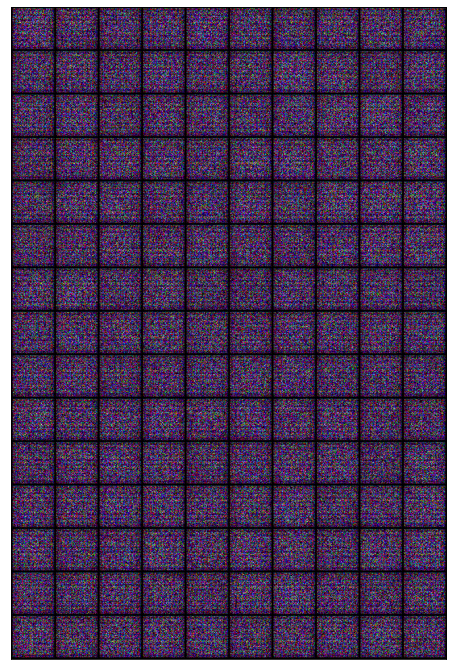

In [ ]:
saveporg(fixed_latent, 0)

In [ ]:
def fit(epochs, lr, idx=1):

  torch.cuda.empty_cache()

  losses_gen= []
  losses_dis=[] 
  fake_scores=[] 
  real_scores=[]

  opt_d= torch.optim.Adam(discriminator.parameters(), lr, betas=(0.5,0.8,0.9))
  opt_g= torch.optim.Adam(generator.parameters(), lr, betas=(0.5,0.8,0.9))

  for epoch in range(epochs):

    for real_image, _ in tqdm(train_loader):

      rscore, fscore, dloss= discri_train(real_image, opt_d)

      gloss= genera_train(opt_g)

    losses_gen.append(gloss)
    losses_dis.append(dloss)
    real_scores.append(rscore) 
    fake_scores.append(fscore)

    print('Epoch [{}], losses_generator: {:.4f}, losses_discriminator: {:.4f}, real score: {:.4f}, fake_score{:.4f}'.
          format(epoch, losses_gen, losses_dis, real_scores, fake_scores))
    
    saveporg(fixed_latent, idx+epoch, show=False)

    return losses_dis, losses_gen, real_scores, fake_scores

In [ ]:
lr= 0.002
epochs= 30

In [ ]:
history= fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ValueError: ignored